In [28]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import flatten
from IPython.display import HTML, display
import os
import pandas as pd
from sklearn import preprocessing
%matplotlib inline

In [ ]:
# The code is from aleje. ref: https://github.com/aleju/imgaug
"""
Data augmentation

args: 
i: input images
o: the name of output file
m: minimum number of images for each class

yields:
images aftef affine transformation
"""
! python utility/dataAugmentation.py -i '..//..//datasets_collection//Traffic_Sign_Classifier//train.p' -m 600

## Examples of data after data augmentation

In [2]:
display(HTML("<table><tr><td>Origin image</td><td>Affine Transformed images</td></tr> <tr><td><img src='./img/sample_traffic_sign.jpg' style='width: 500px;'></td><td><img src='./img/dataAugment.png' style='width: 500px;'></td></tr></table>"))

Origin image,Affine Transformed images
,


In [29]:
def read_data_sets(file):
    """
    Load pickled data
    args:
        file   (str)     path to datasets 
    yields:
        features and label of datasets (numpy array)
    """
    with open(file, mode='rb') as f:
        return pickle.load(f)

In [30]:
data_rel_path = "..\\..\\datasets_collection\\Traffic_Sign_Classifier"

train = read_data_sets(os.path.join(data_rel_path, "aug_train_600.p"))
valid= read_data_sets(os.path.join(data_rel_path, "valid.p")) 
test = read_data_sets(os.path.join(data_rel_path, "test.p")) 

signNames_pd = pd.read_csv(os.path.join(data_rel_path, "signnames.csv"))

In [31]:
image_shape = train['features'][0].shape
n_classes = len(signNames_pd["ClassId"])

In [32]:
def normalize(images):
    m = images.shape[0]
    flat_img = images.reshape((m,-1))
    print (images.shape)
    print (flat_img.shape)
    _min = np.amin(images, axis=(1,2,3)).reshape(m,-1)
    _max = np.amax(images, axis=(1,2,3)).reshape(m,-1)
    norm_imgs = ((flat_img - _min) / (_max - _min))
    return norm_imgs.reshape(images.shape)

In [33]:
valid['features'] = normalize(valid['features'])
train['features'] = normalize(train['features']) 
test['features'] = normalize(test['features'])

(4410, 32, 32, 3)
(4410, 3072)
(41469, 32, 32, 3)
(41469, 3072)
(12630, 32, 32, 3)
(12630, 3072)


In [34]:
def OneHotEncoding(y_class):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_class)
    return lb

In [35]:
ohe = OneHotEncoding(signNames_pd["ClassId"])

In [36]:
train['labels'] = ohe.transform(train['labels']).astype(np.float64)
valid['labels'] = ohe.transform(valid['labels']).astype(np.float64)
test['labels'] = ohe.transform(test['labels']).astype(np.float64)

In [37]:
# from sklearn.model_selection import train_test_split
# """
# shuffeling
# """
# train['features'], valid['features'], train['labels'], valid['labels'] = train_test_split( train['features'], 
#                                                                                            train['labels'],
#                                                                                            test_size=0.2,
#                                                                                            random_state=1)    

In [37]:
def conv2fc(input_height, input_width, filter_size, stride, layers):
    
    con2fc_height = input_height
    con2fc_width = input_width
    print (con2fc_height, con2fc_width)
    for i in layers:
        
        con2fc_height = np.ceil((con2fc_height - filter_size[i] + 1) / stride[i])
        con2fc_width = np.ceil((con2fc_width - filter_size[i] + 1) / stride[i])
        print (con2fc_height, con2fc_width)
    return int(con2fc_height) * int(con2fc_width)

In [38]:
def conv2d(x, W, b, stride):
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k, s):
    # Tensor input is 4-D: [Batch Size, Height, Width, Feature(Channel)]
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding='VALID')

def fclayer(x,w,b):
    return tf.nn.xw_plus_b(tf.contrib.layers.flatten(x), w, b)

In [39]:
LEARNING_RATE = 0.0001

In [43]:
"""
Set neural network parameters
"""

layers = ['conv_1', 'maxpool_1', 'conv_2', 'maxpool_2']
# layers = ['conv_1', 'conv_2']
layer_input = {
     'depth': train['features'].shape[3]
    ,'height': train['features'].shape[1]
    ,'width': train['features'].shape[2]
}

layer_depth = {
    'conv1': 32,
    'conv2': 128,
    'fc1': 1024,
    'fc2': 1024,
    'fc3': n_classes
}

filter_size={
    'conv_1': 3
    ,'conv_2': 3
    ,'maxpool_1': 2
    ,'maxpool_2': 2
}

stride = {
    'conv_1': 1
    ,'conv_2': 1
    ,'maxpool_1': 2
    ,'maxpool_2': 2
}

conv2fc_num = conv2fc(layer_input["height"], layer_input["width"], filter_size, stride, layers)
print (conv2fc_num)

# xavier_initializer
# ref https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer
# tf.truncated_normal(shape=[dims[l-1],dims[l]], mean=mu[l], stddev=std[l], dtype=tf.float64)


for key,val in sorted(layer_depth.items()):
    print("Layer %4s depth is %s"%(key,val))

32 32
30.0 30.0
15.0 15.0
13.0 13.0
6.0 6.0
36
Layer conv1 depth is 32
Layer conv2 depth is 128
Layer  fc1 depth is 1024
Layer  fc2 depth is 1024
Layer  fc3 depth is 43


In [41]:
print(conv2fc_num)
print (layer_depth['conv2'])
print(conv2fc_num*layer_depth['conv2'])

784
128
100352


In [42]:
weights = None
biases = None
net = None
saver = None

# reset graph
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape=[None,image_shape[0],image_shape[1],image_shape[2]], name='InputData')  # (none, 32, 32, 3)
    y = tf.placeholder(tf.float32, name='LabelData')

    with tf.variable_scope('Weight_Bias', reuse=False):
        weights = {
            'conv1': tf.get_variable("conv1w", shape=[filter_size['conv_1'], filter_size['conv_1'], image_shape[2], layer_depth['conv1']], initializer=tf.contrib.layers.xavier_initializer()),
            'conv2': tf.get_variable("conv2w", shape=[filter_size['conv_2'], filter_size['conv_2'], layer_depth['conv1'], layer_depth['conv2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc1':  tf.get_variable("fc1w", shape=[conv2fc_num*layer_depth['conv2'], layer_depth['fc1']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc2':  tf.get_variable("fc2w", shape=[layer_depth['fc1'], layer_depth['fc2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc3':  tf.get_variable("fc3w", shape=[layer_depth['fc2'], layer_depth['fc3']], initializer=tf.contrib.layers.xavier_initializer())
        }
        #image_shape[0]*image_shape[1]*layer_depth['conv2']
        for key,val in sorted(weights.items()):
            print("Weights for %4s: %s"%(key,val))

        biases = {
            'conv1': tf.get_variable("conv1b", shape=[layer_depth['conv1']], initializer=tf.contrib.layers.xavier_initializer()),
            'conv2': tf.get_variable("conv2b", shape=[layer_depth['conv2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc1': tf.get_variable("fc1b", shape=[layer_depth['fc1']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc2': tf.get_variable("fc2b", shape=[layer_depth['fc2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc3': tf.get_variable("fc3b", shape=[layer_depth['fc3']], initializer=tf.contrib.layers.xavier_initializer())
        }


    with tf.name_scope('layer_1'):
        net = conv2d(x,weights['conv1']
                     ,biases['conv1']
                     , stride['conv_1'])
        
    with tf.name_scope('layer_2'):
        net = conv2d(net,weights['conv2']
                     ,biases['conv2']
                     , stride['conv_2'])

    with tf.name_scope('layer_3'):
        net = fclayer(net,weights['fc1'],biases['fc1'])
        net = tf.nn.relu(net)
        
    with tf.name_scope('layer_4'):
        net = fclayer(net,weights['fc2'],biases['fc2'])
        net = tf.nn.relu(net)
        
    with tf.name_scope('layer_5'):
        net = fclayer(net,weights['fc3'],biases['fc3'])


    # Loss computation
    with tf.name_scope('Loss'):
        prediction = tf.nn.softmax(net)
        cross_entropy = -tf.reduce_sum(y * tf.log(prediction + 1e-6), reduction_indices=1)
        loss = tf.reduce_mean(cross_entropy)

    # Accuracy computation
    with tf.name_scope('Accuracy'):
        is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    with tf.name_scope('SGD'):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)        
        
    # Create a summary to monitor cost tensor
    tf.summary.scalar("loss", loss)
    # Create a summary to monitor accuracy tensor
    tf.summary.scalar("accuracy", accuracy)
    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()
    
    saver = tf.train.Saver()
    print()
    print ("scope","name", "shape","type")
    for i in (tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)):
        print (i)

Weights for conv1: <tf.Variable 'Weight_Bias/conv1w:0' shape=(3, 3, 3, 32) dtype=float32_ref>
Weights for conv2: <tf.Variable 'Weight_Bias/conv2w:0' shape=(3, 3, 32, 128) dtype=float32_ref>
Weights for  fc1: <tf.Variable 'Weight_Bias/fc1w:0' shape=(100352, 1024) dtype=float32_ref>
Weights for  fc2: <tf.Variable 'Weight_Bias/fc2w:0' shape=(1024, 1024) dtype=float32_ref>
Weights for  fc3: <tf.Variable 'Weight_Bias/fc3w:0' shape=(1024, 43) dtype=float32_ref>

scope name shape type
<tf.Variable 'Weight_Bias/conv1w:0' shape=(3, 3, 3, 32) dtype=float32_ref>
<tf.Variable 'Weight_Bias/conv2w:0' shape=(3, 3, 32, 128) dtype=float32_ref>
<tf.Variable 'Weight_Bias/fc1w:0' shape=(100352, 1024) dtype=float32_ref>
<tf.Variable 'Weight_Bias/fc2w:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'Weight_Bias/fc3w:0' shape=(1024, 43) dtype=float32_ref>
<tf.Variable 'Weight_Bias/conv1b:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'Weight_Bias/conv2b:0' shape=(128,) dtype=float32_ref>
<tf.Variable '

When creating a tf.Graph called graph and set it as default for the with graph.as_default(): block. This means that all of the variables are created in graph, and if you print `tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)`, you should see a list of your variables.

However, you exit the with block before creating (i) `the tf.Session`, and (ii) the `tf.train.Saver`. This means that the session and saver are created in a different graph (the global default `tf.Graph` that is used when you don't explicitly create one and set it as default), which doesn't contain any variables or any nodes at all.

```python
with graph.as_default():
    # [Variable and model creation goes here.]

    saver = tf.train.Saver()  # Gets all variables in `graph`.

with tf.Session(graph=graph) as sess:
    saver.restore(sess)
    # Do some work with the model....
```

In [44]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[]

* Restore pretrained model (not used)

## train model

In [59]:
batches = []
loss_epoch = []
train_acc_epoch = []
valid_acc_epoch = []
validation_accuracy = 0.0
EPOCHS = 25
BATCH_SIZE = 64

batch_count = int(len(train['features']) / BATCH_SIZE)
# Add ops to save and restore all the variables.

# Start training
with tf.Session(graph=g, config=tf.ConfigProto(log_device_placement=True)) as sess:
        
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Run the initializer
    sess.run(init)

    # op to write logs to Tensorboard
    train_writer = tf.summary.FileWriter(logdir="logs", graph=g, filename_suffix="mynet_A")

    for epoch in range(EPOCHS): # EPOCHS = 2
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch + 1, EPOCHS), unit='batches')

        for batch_i in batches_pbar:
            batch_start = batch_i * BATCH_SIZE
            batch_features = train['features'][batch_start:batch_start + BATCH_SIZE]
            batch_labels = train['labels'][batch_start:batch_start + BATCH_SIZE]

            _, l, summary = sess.run(
                [optimizer, loss, merged_summary_op],
                feed_dict={x: batch_features, y: batch_labels})
            # print (epoch * batch_count + batch_i)
            train_writer.add_summary(summary, epoch * BATCH_SIZE + batch_i)

        training_accuracy = sess.run(
            accuracy,
            feed_dict={x: batch_features, y: batch_labels}
        )

        idx = np.random.randint(len(valid['features']), size=int(BATCH_SIZE * .2))

        validation_accuracy = sess.run(
            accuracy,
            feed_dict={x: valid['features'][idx,:], y: valid['labels'][idx,:]}
        )

        print('Epoch {:>2}/{}'.format(epoch + 1, EPOCHS))
        print("loss is {}".format(l))
        print("training set accuracy is {}".format(training_accuracy))
        print("validation set accuracy is {}".format(validation_accuracy))


        batches.append(len(batches))
        loss_epoch.append(l)
        train_acc_epoch.append(training_accuracy)
        valid_acc_epoch.append(validation_accuracy)
    
    # Save model weights to disk
    # global_step refer to the number of batches seen by the graph.
    model_path = "model//{0}//valid_{1:.2f}.ckpt".format("mynet_A", validation_accuracy)
    save_path = saver.save(sess, model_path, global_step=100)
    print("Model saved in file: %s" % save_path)
    


Epoch  1/25: 100%|██████████████████████| 518/518 [11:56<00:00,  1.37s/batches]


Epoch  1/25
loss is 0.5092287063598633
training set accuracy is 0.890625
validation set accuracy is 0.75


Epoch  2/25: 100%|██████████████████████| 518/518 [11:36<00:00,  1.41s/batches]


Epoch  2/25
loss is 0.17784176766872406
training set accuracy is 0.9375
validation set accuracy is 1.0


Epoch  3/25: 100%|██████████████████████| 518/518 [12:09<00:00,  1.40s/batches]


Epoch  3/25
loss is 0.029606973752379417
training set accuracy is 1.0
validation set accuracy is 1.0


Epoch  4/25: 100%|██████████████████████| 518/518 [12:25<00:00,  1.49s/batches]


Epoch  4/25
loss is 0.012548370286822319
training set accuracy is 1.0
validation set accuracy is 0.9166666865348816


Epoch  5/25: 100%|██████████████████████| 518/518 [12:29<00:00,  1.41s/batches]


Epoch  5/25
loss is 0.009400955401360989
training set accuracy is 1.0
validation set accuracy is 1.0


Epoch  6/25: 100%|██████████████████████| 518/518 [12:21<00:00,  1.45s/batches]


Epoch  6/25
loss is 0.004621051251888275
training set accuracy is 1.0
validation set accuracy is 1.0


Epoch  7/25: 100%|██████████████████████| 518/518 [12:04<00:00,  1.35s/batches]


Epoch  7/25
loss is 0.04816998541355133
training set accuracy is 1.0
validation set accuracy is 1.0


Epoch  8/25: 100%|██████████████████████| 518/518 [11:47<00:00,  1.62s/batches]


Epoch  8/25
loss is 0.0029015452601015568
training set accuracy is 1.0
validation set accuracy is 1.0


Epoch  9/25: 100%|██████████████████████| 518/518 [12:02<00:00,  1.40s/batches]


Epoch  9/25
loss is 0.04973810538649559
training set accuracy is 1.0
validation set accuracy is 1.0


Epoch 10/25: 100%|██████████████████████| 518/518 [11:52<00:00,  1.44s/batches]


Epoch 10/25
loss is 0.00046852981904521585
training set accuracy is 1.0
validation set accuracy is 0.9166666865348816


Epoch 11/25: 100%|██████████████████████| 518/518 [12:03<00:00,  1.37s/batches]


Epoch 11/25
loss is 0.020012687891721725
training set accuracy is 1.0
validation set accuracy is 1.0


Epoch 12/25: 100%|██████████████████████| 518/518 [11:58<00:00,  1.40s/batches]


Epoch 12/25
loss is 0.0014378397027030587
training set accuracy is 1.0
validation set accuracy is 1.0


Epoch 13/25:  25%|█████▍                | 129/518 [03:07<08:44,  1.35s/batches]

KeyboardInterrupt: 

* Tensorflow models look like this

In [107]:
display(HTML("<img src='./img/tf_saver.PNG' style='width: 700px;'>"))

* tensorboard run 
```python
python -m tensorboard.main --logdir=logs
```

* view the graph 
```
localhost:6006
```

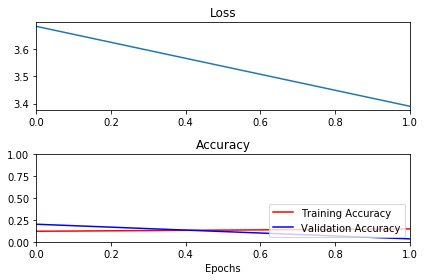

In [102]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_epoch)
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_epoch, 'b', label='Validation Accuracy')
acc_plot.set_xlabel('Epochs')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

In [103]:
display(HTML("<table><tr><td>Origin image</td><td>Model graph</td></tr> <tr><td><img src='./img/Model_architecture_2.PNG' style='width: 700px;'></td><td><img src='./img/Model_architecture.png' style='width: 700px;'></td></tr></table>"))

Origin image,Model graph
,


In [104]:
show_graph(g)

# Importing a pre-trained model

## Create the network
`import_meta_graph` loads the network defined in `.meta` file to the current graph, so,this will create the graph/network. After that, we still need to load the pretrained parameters on this graph.

ex: 
```python
saver = tf.train.import_meta_graph('my_test_model-1000.meta')
```

## Load the parameters
We can restore the parameters of the network by calling restore on this saver which is an instance of `tf.train.Saver()` class.

Once you can restore any pre-trained model, you can do fine-tuning, transfer learning or further training.

There is only one checkpoint. If you build another model, the checkpoint file will be overwritten. Each model should be saved in its own direcotry 